# kaggle入门: 数字识别器

## 1. 概述

### 描述

&emsp;&emsp;如果……就从这里开始吧……
<br/>
&emsp;&emsp;您具有一些 R 或 Python 和机器学习基础知识的经验，但对计算机视觉还不熟悉。这项比赛是使用包括预提取特征在内的经典数据集来介绍神经网络等技术的完美方式。
<br/>
比赛描述
<br/>
&emsp;&emsp;MNIST（“改良版美国国家标准与技术研究院”）是事实上的计算机视觉“Hello World”数据集。自 1999 年发布以来，这一经典的手写图像数据集一直是对分类算法进行基准测试的基础。随着新的机器学习技术的出现，MNIST 仍然是研究人员和学习者的可靠资源。
<br/>
&emsp;&emsp;在本次比赛中，您的目标是从数万张手写图像的数据集中正确识别数字。我们精心挑选了一组教程式内核，涵盖了从回归到神经网络的所有内容。我们鼓励您尝试不同的算法，以亲自了解哪种算法效果最好以及如何比较各种技术。

### 数据集

数据文件
- **train.csv**: 包含手绘数字的灰度图像（0-9）。
- **test.csv**: 与训练集相同，但不包含标签列。

图像信息
- 每幅图像的尺寸为 **28 x 28** 像素，总共 **784** 像素。
- 每个像素的值为 **0** 到 **255** 之间的整数，数字越大表示越暗。

数据结构
- **训练数据集 (train.csv)**:
  - **785** 列
    - 第一列称为“标签”，表示用户绘制的数字。
    - 其余 **784** 列包含相关图像的像素值，列名为 `pixelx`，其中 `x` 为 **0 到 783** 之间的整数（含）。

- 像素位置的计算方法：
  - 将 `x` 分解为 `x = i * 28 + j`，其中 `i` 和 `j` 为 **0 到 27** 之间的整数（含）。
  - 例如，`pixel31` 表示位于左侧第四列、顶部第二行的像素。

图像像素示例
|    | 0    | 1    | 2    | 3    | ... | 26   | 27   |
|----|------|------|------|------|-----|------|------|
| 0  | 000  | 001  | 002  | 003  | ... | 026  | 027  |
| 1  | 028  | 029  | 030  | 031  | ... | 054  | 055  |
| 2  | 056  | 057  | 058  | 059  | ... | 082  | 083  |
|... | ...  | ...  | ...  | ...  | ... | ...  | ...  |
| 27 | 728  | 729  | 730  | 731  | ... | 754  | 755  |
| 28 | 756  | 757  | 758  | 759  | ... | 782  | 783  |

提交格式
您的提交文件应包含以下格式：对于测试集中的 **28000** 张图像中的每一张，输出一行，其中包含 **ImageId** 和您预测的数字。

示例：


## 导入库

In [1]:
import os
import warnings
from typing import Tuple, Optional
from dataclasses import dataclass

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import d2l.torch as d2l
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, TensorDataset

warnings.filterwarnings("ignore")

## 数据下载

In [2]:
if not os.path.exists("./data"):
    !kaggle competitions download -c digit-recognizer
    !mkdir ./data
    !unzip *.zip -d ./data/
    !rm -rf *.zip

In [3]:
def read_data() -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    train_df = pd.read_csv('./data/train.csv')
    test_df = pd.read_csv('./data/test.csv')
    X_train, y_train = train_df.values[:, 1:].reshape(-1, 28, 28), train_df.values[:, 0].reshape(-1, 1),
    X_test = test_df.values.reshape(-1, 28, 28)
    # y_train = np.eye(10)[y_train]

    return X_train, X_test, y_train

In [4]:
X_train, X_test, y_train = read_data()

In [5]:
X_train.shape, y_train.shape, X_test.shape

((42000, 28, 28), (42000, 1), (28000, 28, 28))

In [6]:
def display_digits(X, y, num_images=10):
    # 随机选择要显示的图像索引
    indices = np.random.choice(X.shape[0], size=num_images, replace=False)
    
    # 创建一个画布
    plt.figure(figsize=(10, 10))
    
    # 循环显示每个图像
    for i, idx in enumerate(indices):
        plt.subplot(1, num_images, i + 1)  # 一行显示多个图像
        plt.imshow(X[idx], cmap='gray')  # 使用灰度色图显示图像
        plt.title(f'Label: {y[idx][0]}')  # 显示标签
        plt.axis('off')  # 不显示坐标轴
        
    plt.tight_layout()  # 调整布局
    plt.show()


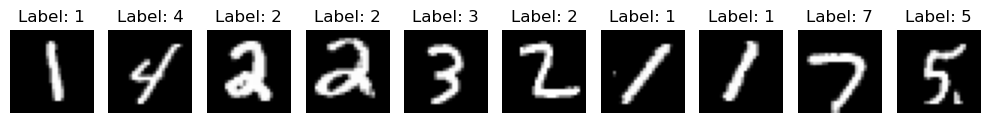

In [7]:
display_digits(X_train, y_train)

## 建模

In [8]:
@dataclass
class SplitData():
    X_train: Optional[np.ndarray] = None
    X_vaild: Optional[np.ndarray] = None
    y_train: Optional[np.ndarray] = None
    y_vaild: Optional[np.ndarray] = None

### 1. XGBoost

In [9]:
xgb_data = SplitData(*train_test_split(X_train.reshape(-1, 28*28), y_train, random_state=42))

In [10]:
xgb_model = XGBClassifier(objective='multi:softmax', num_class=10, eval_metric='mlogloss')
xgb_model.fit(xgb_data.X_train, xgb_data.y_train)
y_pred = xgb_model.predict(xgb_data.X_vaild)

In [11]:
acc_score = accuracy_score(xgb_data.y_vaild, y_pred) # type: ignore
acc_score

0.9727619047619047

### 2. MLP

In [12]:
mlp_data = SplitData(*train_test_split(X_train.reshape(-1, 28*28)/255, y_train, test_size=0.2, random_state=42))

In [13]:
mlp_model = MLPClassifier(
    hidden_layer_sizes=(100, 50),  # 两层，第一层100个神经元，第二层50个
    activation='relu',              # 使用ReLU激活函数
    solver='adam',                  # Adam优化器
    alpha=0.0001,                   # L2正则化系数
    batch_size=200,                 # 每批次200个样本
    learning_rate='adaptive',        # 自适应学习率
    learning_rate_init=0.001,       # 初始学习率
    max_iter=300,                   # 最大迭代次数
    random_state=42                  # 随机数种子
)

In [14]:
mlp_model.fit(mlp_data.X_train, mlp_data.y_train) # type: ignore
y_pred = mlp_model.predict(mlp_data.X_vaild) # type: ignore

In [15]:
accuracy_score(mlp_data.y_vaild, y_pred) # type: ignore

0.9726190476190476

### 3. CNN: LeNet-5

In [16]:
letnet_data = SplitData(*train_test_split(X_train/255, y_train, test_size=0.2, random_state=42))
# 将数据转换为 PyTorch 张量
letnet_data.X_train = torch.tensor(letnet_data.X_train, dtype=torch.float32).unsqueeze(1)  # type: ignore # 形状变为 (42000, 1, 28, 28)
letnet_data.y_train = torch.tensor(letnet_data.y_train, dtype=torch.long).squeeze()  # type: ignore # 形状变为 (42000,)
letnet_data.X_vaild = torch.tensor(letnet_data.X_vaild, dtype=torch.float32).unsqueeze(1)  # type: ignore # 形状变为 (28000, 1, 28, 28)
letnet_data.y_vaild = torch.tensor(letnet_data.y_vaild, dtype=torch.long).squeeze()  # type: ignore # 形状变为 (42000,)

In [17]:
# 创建 PyTorch 数据加载器
train_dataset = TensorDataset(letnet_data.X_train, letnet_data.y_train) # type: ignore
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
vaild_dataset = TensorDataset(letnet_data.X_vaild, letnet_data.y_vaild) # type: ignore
vaild_loader = DataLoader(vaild_dataset, batch_size=64, shuffle=True)

In [18]:
class ReShapeLayer(nn.Module):
    def __init__(self):
        super().__init__()
    def forward(self, x):
        return x.reshape(-1, 1, 28, 28)

net = nn.Sequential(
    ReShapeLayer(),
    
    nn.Conv2d(1, 6, kernel_size=5, padding=2), nn.Sigmoid(), nn.AvgPool2d(kernel_size=2, stride=2),

    nn.Conv2d(6, 16, kernel_size=5), nn.ReLU(), nn.AvgPool2d(kernel_size=2, stride=2),

    nn.Flatten(),
    nn.Linear(16 * 5 * 5, 120), nn.ReLU(), nn.Dropout(0.3), 
    nn.Linear(120, 84), nn.ReLU(), nn.Dropout(0.3), 
    nn.Linear(84, 10),  # nn.Softmax()    
)

In [19]:
X = torch.rand(size=(4, 28, 28), dtype=torch.float32)
for layer in net:
    X = layer(X)
    print(layer.__class__.__name__, 'output shape: ', X.shape)

ReShapeLayer output shape:  torch.Size([4, 1, 28, 28])
Conv2d output shape:  torch.Size([4, 6, 28, 28])
Sigmoid output shape:  torch.Size([4, 6, 28, 28])
AvgPool2d output shape:  torch.Size([4, 6, 14, 14])
Conv2d output shape:  torch.Size([4, 16, 10, 10])
ReLU output shape:  torch.Size([4, 16, 10, 10])
AvgPool2d output shape:  torch.Size([4, 16, 5, 5])
Flatten output shape:  torch.Size([4, 400])
Linear output shape:  torch.Size([4, 120])
ReLU output shape:  torch.Size([4, 120])
Dropout output shape:  torch.Size([4, 120])
Linear output shape:  torch.Size([4, 84])
ReLU output shape:  torch.Size([4, 84])
Dropout output shape:  torch.Size([4, 84])
Linear output shape:  torch.Size([4, 10])


loss 0.015, train acc 0.995, test acc 0.989
11621.8 examples/sec on cpu


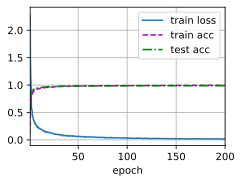

In [20]:
d2l.train_ch6(net, train_loader, vaild_loader, 200, 0.03, d2l.try_gpu())

In [21]:
# 预测测试集
net.eval()
with torch.no_grad():
    predictions = net(torch.tensor(X_test, dtype=torch.float32).unsqueeze(1) / 255).argmax(dim=1)

In [22]:
# 输出预测结果
predictions = predictions.cpu().numpy()
output = np.column_stack((np.arange(1, len(predictions) + 1), predictions))

In [23]:
predictions.shape

(28000,)

In [24]:
output = pd.DataFrame({'ImageId': np.arange(1, predictions.shape[0] + 1), 'Label': predictions})
output.to_csv('./data/submission.csv', index=False)
print("Your submission was successfully saved!")

Your submission was successfully saved!


In [25]:
!kaggle competitions submit -c digit-recognizer -f ./data/submission.csv -m "LetNet: ReLU dropout"

100%|█████████████████████████████████████████| 208k/208k [00:01<00:00, 143kB/s]
Successfully submitted to Digit Recognizer